<a href="https://colab.research.google.com/github/adamggibbs/marine-carbonate-system-ml-prediction/blob/master/model_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [20]:
# IMPORTS

import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras.layers.experimental import preprocessing
from sklearn import metrics

# data dirs
data_dir = '/content/drive/MyDrive/Adam Gibbs/data/'
model_dir = data_dir + 'models/'
training_dir=data_dir + 'training/'
# ship_dir = data_dir + 'ship/'
# glider_dir = data_dir + 'glider/'
# wcoa_dir = data_dir + 'wcoa/'

# Load in data files and model

In [21]:
# load in txt data

train_inputs = np.loadtxt(training_dir+'training_tpso_input.csv', 
                        delimiter=",", 
                        dtype='float')
train_outputs = np.loadtxt(training_dir+'training_ph_output.csv', 
                        delimiter=",", 
                        dtype='float')

val_inputs = np.loadtxt(training_dir+'validation_tpso_input.csv', 
                        delimiter=",", 
                        dtype='float')
val_outputs = np.loadtxt(training_dir+'validation_ph_output.csv', 
                        delimiter=",", 
                        dtype='float')

test_inputs = np.loadtxt(training_dir+'testing_tpso_input.csv', 
                        delimiter=",", 
                        dtype='float')
test_outputs = np.loadtxt(training_dir+'testing_ph_output.csv', 
                        delimiter=",", 
                        dtype='float')

canyonb_pH_outputs = np.loadtxt(training_dir+'canyonb_outputs.csv', 
                        delimiter=",", 
                        dtype='float')

display(train_inputs.shape)
display(train_outputs.shape)

display(val_inputs.shape)
display(val_outputs.shape)

display(test_inputs.shape)
display(test_outputs.shape)

display(canyonb_pH_outputs.shape)


(385716, 7)

(385716,)

(128572, 7)

(128572,)

(128572, 7)

(128572,)

(128572,)

In [22]:
# LOAD IN MODELS
model_name = 'DNN'
loaded_model = tf.keras.models.load_model(model_dir+'DNN(64,64,64,64)mse', compile=True)
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 7)                 15        
_________________________________________________________________
dense (Dense)                (None, 64)                512       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 13,072
Trainable params: 13,057
Non-trainable params: 15
___________________________________________________

In [23]:
test_results = {}
train_performance = loaded_model.evaluate(train_inputs, train_outputs)
val_performance = loaded_model.evaluate(val_inputs, val_outputs) 
test_performance = loaded_model.evaluate(test_inputs, test_outputs) 

4018/4018 [==============================] - 6s 2ms/step - loss: 6.5538e-05 - mean_absolute_error: 0.0045 - mean_squared_error: 6.5538e-05 - root_mean_squared_error: 0.0081


# Calculate Prediction and Depth Arrays
### Run these cells before running the following analyses 

In [24]:
# make predictions on testing dataset with neural network
test_predictions = loaded_model.predict(test_inputs, verbose=1).flatten()
print('Calculated {} pH estimates with model {}'.format(len(test_predictions), model_name))

4018/4018 [==============================] - 5s 1ms/step
Calculated 128572 pH estimates with model DNN


In [25]:
# FUNCTION: CONVERT PRESSURE TO DEPTH
# Python version of the following MATLAB function
'''
% SW_DPTH    Depth from pressure
%===========================================================================
% SW_DPTH   $Id: sw_dpth.m,v 1.1 2003/12/12 04:23:22 pen078 Exp $
%           Copyright (C) CSIRO, Phil Morgan 1992.
%
% USAGE:  dpth = sw_dpth(P,LAT)
%
% DESCRIPTION:
%    Calculates depth in metres from pressure in dbars.
%
% INPUT:  (all must have same dimensions)
%   P   = Pressure    [db]
%   LAT = Latitude in decimal degress north [-90..+90]
%         (lat may have dimensions 1x1 or 1xn where P(mxn).
%
% OUTPUT:
%  dpth = depth [metres]
%
% AUTHOR:  Phil Morgan 92-04-06  (morgan@ml.csiro.au)
%
% DISCLAIMER:
%   This software is provided "as is" without warranty of any kind.
%   See the file sw_copy.m for conditions of use and licence.
%
% REFERENCES:
%    Unesco 1983. Algorithms for computation of fundamental properties of
%    seawater, 1983. _Unesco Tech. Pap. in Mar. Sci._, No. 44, 53 pp.
%=========================================================================
'''
def pres_to_depth(pres, lat):

  # define constants
  DEG2RAD = math.pi/180
  c1 = 9.72659
  c2 = -2.2512E-5
  c3 = 2.279E-10
  c4 = -1.82E-15
  gam_dash = 2.184E-6

  # convert latitude
  LAT = abs(lat)
  X = math.sin(LAT*DEG2RAD)
  X = X*X

  # calculate denomenator and numerator
  denom = 9.780318*(1.0+(5.2788E-3 + 2.36E-5*X)*X) + gam_dash*0.5*pres 
  numer = (((c4 * pres + c3) * pres + c2) * pres + c1) * pres

  # return quotient
  return numer / denom

################################################################################

# FUNCTION: CONVERT ARRAY OF INPUTS TO AN ARRAY OF DEPTHS
def get_depths(input_arr):
  # create numpy array to store depths
  depths = np.zeros(len(input_arr))
  # loop through inputs and calculate depth
  ind = 0
  for input in input_arr:
    depths[ind] = pres_to_depth(input[3], input[1])
    ind += 1
  # return depth array
  return depths

################################################################################

# get depths from inputs
test_depths = get_depths(test_inputs)

In [26]:
# GET DATAPOINTS FROM SHALLOW DEPTHS (<200m)

# loop through depths and get indices of deep datapoints 
ind = 0
inds = []
for depth in test_depths:
  if depth > 200:
    inds.append(ind)
  ind += 1

# delete deep datapoints and store resulting array of shallow datapoints
shallow_test_depths = np.delete(test_depths, inds, axis=0)
shallow_test_predictions = np.delete(test_predictions, inds, axis =0)
shallow_canyonb_pH_outputs = np.delete(canyonb_pH_outputs, inds, axis=0)
shallow_test_outputs = np.delete(test_outputs, inds, axis=0)

# ensure there are no deep datapoints
count = 0
for depth in shallow_test_depths:
  if depth > 200:
    count += 1
print('Number of datapoints of depth greater than 200m: {}'.format(count))

print('Shape of each shallow data array (all should be equal):')
display(shallow_test_depths.shape)
display(shallow_test_predictions.shape)
display(shallow_canyonb_pH_outputs.shape)
display(shallow_test_outputs.shape)

Number of datapoints of depth greater than 200m: 0
Shape of each shallow data array (all should be equal):


(63588,)

(63588,)

(63588,)

(63588,)

# Estimates vs Observations 1-1 Plot

## Overall Dataset

Number of estimations not in range [7.3,8.5]: 1



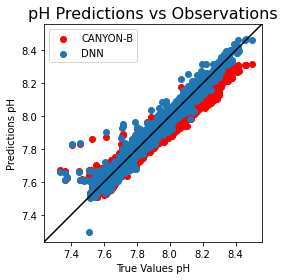

In [27]:
# count how many estimations are outside range test
count = 0
ind = 0
for o in test_predictions:
  if float(o) < 7.3 or float(o) > 8.5:
    count += 1
  ind += 1
# print number of estimations outside range test
print('Number of estimations not in range [7.3,8.5]: {}\n'.format(count))

ax = plt.axes(aspect='equal')

# plot scatter plots of estimations vs observations
# (x=observations, y=estimations, blue=our DNN, red=CANYON-B)
plt.scatter(test_outputs, canyonb_pH_outputs, color='red', label='CANYON-B')
plt.scatter(test_outputs, test_predictions, label='DNN')

# get axis limits from min and max ofdata
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
plt.ylim(lims)
plt.xlim(lims)
# plot a y=x line to show where perfect (estimate=observation) estimates lie
plt.plot(lims,lims, color='black')

# title, label, and legend plot
plt.title('pH Predictions vs Observations', fontsize=16)
plt.xlabel('True Values pH')
plt.ylabel('Predictions pH')
plt.legend()

# show plot
plt.show()

## Shallow Test Dataset

Number of estimations not in range [7.3,8.5]: 1



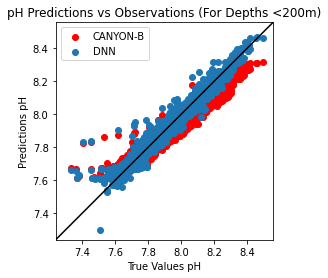

In [28]:
# count how many estimations are outside range test
count = 0
ind = 0
for o in shallow_test_predictions:
  if float(o) < 7.3 or float(o) > 8.5:
    count += 1
  ind += 1
# print number of estimations outside range test
print('Number of estimations not in range [7.3,8.5]: {}\n'.format(count))

ax = plt.axes(aspect='equal')

# plot scatter plots of estimations vs observations
# (x=observations, y=estimations, blue=our DNN, red=CANYON-B)
plt.scatter(shallow_test_outputs, shallow_canyonb_pH_outputs, 
            color='red', label='CANYON-B')
plt.scatter(shallow_test_outputs, shallow_test_predictions, 
            label='DNN')

# get axis limits from min and max ofdata
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
plt.ylim(lims)
plt.xlim(lims)
# plot a y=x line to show where perfect (estimate=observation) estimates lie
plt.plot(lims,lims, color='black')

# title, label, and legend plot
plt.title('pH Predictions vs Observations (For Depths <200m)')
plt.xlabel('True Values pH')
plt.ylabel('Predictions pH')
plt.legend()

# show plot
plt.show()

# Depth vs Error Plot

## DNN Error only 

### Overall Test Dataset

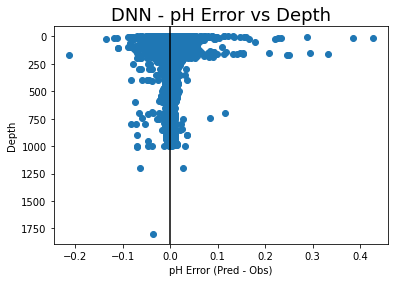

In [29]:

# get errors (estimations - observations)
error = test_predictions - test_outputs

# plot the scatter plots (x=error, y= depth)
plt.scatter(error, test_depths)

# place a vertical line at x=0 to represent error=0
plt.axvline(x=0, color='black')
#invert y-axis to better represent depth
plt.gca().invert_yaxis()

# label plot
plt.title(model_name+' - pH Error vs Depth', fontsize=18)
plt.xlabel('pH Error (Pred - Obs)')
plt.ylabel('Depth')

# show plot
plt.show()

### Shallow Test Dataset

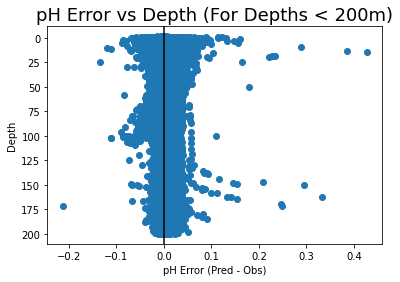

In [30]:

# get errors (estimations - observations)
shallow_error = shallow_test_predictions - shallow_test_outputs

# plot the scatter plots
plt.scatter(shallow_error, shallow_test_depths, label='DNN')

plt.axvline(x=0, color='black')
plt.gca().invert_yaxis()

plt.title('pH Error vs Depth (For Depths < 200m)', fontsize=18)
plt.xlabel('pH Error (Pred - Obs)')
plt.ylabel('Depth')

plt.show()

## DNN & CANYON-B

### Overall Test Dataset

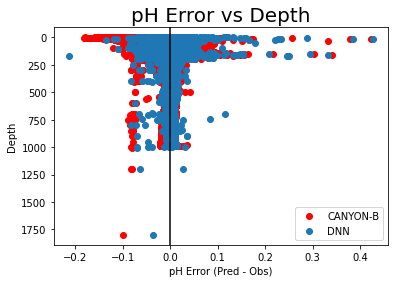

In [31]:
# convert inputs to depths
test_depths = get_depths(test_inputs)

# get errors (estimations - observations)
error = test_predictions - test_outputs
error2 = canyonb_pH_outputs - test_outputs

# plot the scatter plots
plt.scatter(error2, test_depths, color='red', label='CANYON-B')
plt.scatter(error, test_depths, label='DNN')

plt.axvline(x=0, color='black')
plt.gca().invert_yaxis()

plt.title('pH Error vs Depth', fontsize=20)
plt.xlabel('pH Error (Pred - Obs)')
plt.ylabel('Depth')
plt.legend()

plt.show()

### Shallow (<200m) Test Dataset

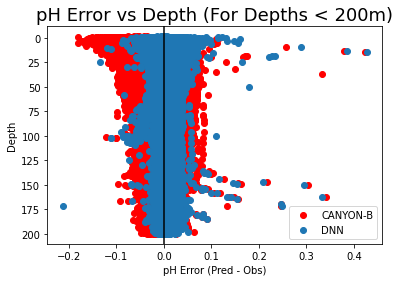

In [32]:

# get errors (estimations - observations)
shallow_error = shallow_test_predictions - shallow_test_outputs
shallow_error2 = shallow_canyonb_pH_outputs - shallow_test_outputs

# plot the scatter plots
plt.scatter(shallow_error2, shallow_test_depths, 
            color='red', label='CANYON-B')
plt.scatter(shallow_error, shallow_test_depths, 
            label='DNN')

plt.axvline(x=0, color='black')
plt.gca().invert_yaxis()

plt.title('pH Error vs Depth (For Depths < 200m)', fontsize=18)
plt.xlabel('pH Error (Pred - Obs)')
plt.ylabel('Depth')
plt.legend()

plt.show()

# Error Metrics
### MAE, MSE, RMSE

## Overall Test Dataset

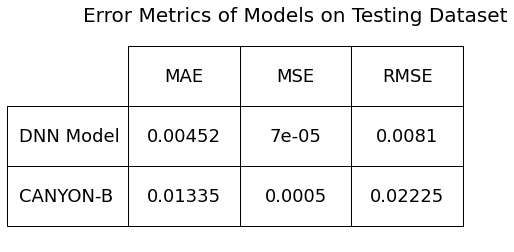

In [33]:
# create numpy array to hold metrics
model_metrics = np.zeros(shape=(2,3))

# get metrics for DNN
mae = metrics.mean_absolute_error(test_outputs, test_predictions)
mse = metrics.mean_squared_error(test_outputs, test_predictions)
rmse = math.sqrt(mse)
# round metrics to 5 decimal places
model_metrics[0][0] = np.round(mae, 5)
model_metrics[0][1] = np.round(mse, 5)
model_metrics[0][2] = np.round(rmse, 5)

# get metrics for CANYON-B
c_mae = metrics.mean_absolute_error(test_outputs, canyonb_pH_outputs)
c_mse = metrics.mean_squared_error(test_outputs, canyonb_pH_outputs)
c_rmse = math.sqrt(c_mse)
# round metrics to 5 decimal places
model_metrics[1][0] = np.round(c_mae, 5)
model_metrics[1][1] = np.round(c_mse, 5)
model_metrics[1][2] = np.round(c_rmse, 5)

# create table
# labels for columns and rows
col_labels = np.array(('MAE', 'MSE', 'RMSE'))
row_labels = np.array(('DNN Model', 'CANYON-B'))
# add data to table
fig, ax = plt.subplots()
table = plt.table(cellText=model_metrics, cellLoc='center', loc='center', 
          rowLabels=row_labels, colLabels=col_labels)
# title plot
plt.title('Error Metrics of Models on Testing Dataset', fontsize=20)
# scale plot
table.set_fontsize(18)
table.scale(1,5)
ax.axis('off')
# show plot
plt.show()


## Shallow Test Dataset

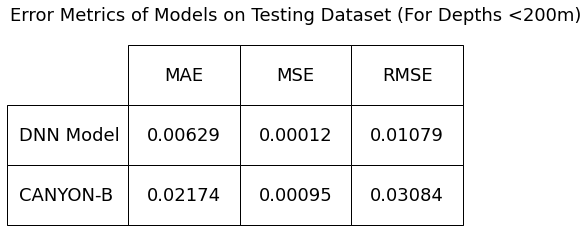

In [34]:
# create numpy array to hold metrics
model_metrics = np.zeros(shape=(2,3))

# get metrics for DNN
mae = metrics.mean_absolute_error(shallow_test_outputs, shallow_test_predictions)
mse = metrics.mean_squared_error(shallow_test_outputs, shallow_test_predictions)
rmse = math.sqrt(mse)
# round metrics to 5 decimal places
model_metrics[0][0] = np.round(mae, 5)
model_metrics[0][1] = np.round(mse, 5)
model_metrics[0][2] = np.round(rmse, 5)

# get metrics for CANYON-B
c_mae = metrics.mean_absolute_error(shallow_test_outputs, shallow_canyonb_pH_outputs)
c_mse = metrics.mean_squared_error(shallow_test_outputs, shallow_canyonb_pH_outputs)
c_rmse = math.sqrt(c_mse)
# round metrics to 5 decimal places
model_metrics[1][0] = np.round(c_mae, 5)
model_metrics[1][1] = np.round(c_mse, 5)
model_metrics[1][2] = np.round(c_rmse, 5)

# create table
# labels for columns and rows
col_labels = np.array(('MAE', 'MSE', 'RMSE'))
row_labels = np.array(('DNN Model', 'CANYON-B'))
# add data to table
fig, ax = plt.subplots()
table = plt.table(cellText=model_metrics, cellLoc='center', loc='center', 
          rowLabels=row_labels, colLabels=col_labels)
# title plot
plt.title('Error Metrics of Models on Testing Dataset (For Depths <200m)', 
          fontsize=18)
# scale plot
table.set_fontsize(18)
table.scale(1,5)
ax.axis('off')
# show plot
plt.show()
